In [1]:
# Run this cell only once then delete it, this just a relacement for running pip install olfpy
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    

install('odfpy')

In [69]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt

In [64]:
def load_data_part1():
    # Emission Data (CO2)
    EU_em_df = pd.read_excel('Data/Table_11.5_Carbon_Dioxide_Emissions_From_Energy_Consumption__Transportation_Sector.xlsx',engine='openpyxl')
    EU_em_annual_df = pd.read_csv('Data/EU_annual_carbon_emission_by_road_transportation.csv',)
    UK_em_df = pd.read_excel('Data/uk-env0201.ods', nrows = 16)
    US_em_df = pd.read_excel('Data/US_em.xlsx',engine='openpyxl')
        # Emissions data Processing
    EU_em_df = EU_em_df.set_index('Month')
    UK_em_df = UK_em_df.transpose()
    
    # Electric Vehicles
    EU_veh_df = pd.read_csv('Data/new-electric-vehicles-in-eu-1.csv')
    UK_veh_df = pd.read_excel('Data/veh0203.ods', nrows= 76)
    US_veh_df = pd.read_excel('Data/10354_epact_vehicle_history_5-21-21.xlsx',engine='openpyxl')
    return EU_em_df, EU_em_annual_df, UK_em_df, US_em_df, EU_veh_df,UK_veh_df, US_veh_df

EU_em_df, EU_em_annual_df, UK_em_df, US_em_df, EU_veh_df,UK_veh_df, US_veh_df = load_data_part1()

def load_data_part2():
    # Secondary Data 
        # Air pollution
            # UK 1970-2019/2022
    UK_nox_annual_df = pd.read_csv('Data/Figure06_NOx_time_series.csv')
    UK_pm_all_annual_df = pd.read_csv('Data/Figure03_PM_time_series.csv')
            
            # USA Since 1970-2020, plz Access through column id(numbers)
    USA_nox_annual_df = pd.read_csv('Data/US_nox_em_time_series.csv') # National Emissions Totals (thousands of tons)
    USA_pm_10_annual_df = pd.read_csv('Data/US_pm10_year.csv')        #
    USA_pm_2_5_annual_df = pd.read_csv('Data/US_pm2_5_year.csv')
    
    USA_pm_2_5_annual_df = USA_pm_2_5_annual_df.transpose()
    USA_pm_10_annual_df = USA_pm_10_annual_df.transpose()
            
            # OCED DATA
    OCED_PM10_df = pd.read_excel('Data/PM10_ROAD_OCED_WORLD_DATA.xlsx',engine='openpyxl')
    OCED_NOX_df = pd.read_excel('Data/NOX_ROAD_OCED_WORLD_DATA.xlsx',engine='openpyxl')
    OCED_PM2_5_df = pd.read_excel('Data/PM2_5_ROAD_OCED_WORLD_DATA.xlsx',engine='openpyxl')
    
    return UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df
    
UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df = load_data_part2()

# Eric: Simpler ways to read the data
# calling head() method  
# storing in new variable 
data_top = OCED_PM2_5_df
    
# display 
data_top 

D:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Austria,9.061,NaN,NaN,NaN,NaN,9.911,NaN,NaN,NaN,...,6.727,6.185,5.584,5.148,4.794,4.424,4.166,3.830,3.566,3.339
1,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.473,6.724,6.103,5.527,5.109,4.977,4.631,4.232,3.938,3.666
2,Canada,73.999,69.456,68.619,71.830,76.760,78.519,78.469,80.510,77.450,...,54.248,48.694,44.353,42.207,39.217,35.511,31.875,33.592,35.229,35.197
3,Chile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.960,4.900,4.534,5.342,5.923,6.681,6.747,7.491,14.858,NaN
4,Czech Republic,14.238,12.864,11.767,10.583,9.996,8.572,7.818,7.021,7.490,...,5.427,5.025,4.842,4.670,4.653,4.534,4.506,4.514,4.483,4.333
5,Denmark,9.780,10.056,9.486,9.394,9.237,9.173,8.612,8.132,7.602,...,4.501,4.150,3.835,3.607,3.301,3.066,2.903,2.695,2.531,2.297
6,Estonia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.709,0.678,0.649,0.589,0.583,0.565,0.528,0.513,0.507,0.484
7,Finland,13.659,13.038,12.365,11.778,11.209,10.580,9.932,9.641,9.186,...,5.095,4.778,4.612,4.300,4.059,3.754,3.486,3.319,3.161,2.963
8,France,92.310,98.246,101.741,104.257,101.310,102.947,102.065,98.663,99.968,...,50.312,47.171,43.799,41.000,37.746,35.558,32.684,30.486,27.702,25.764
9,Germany,NaN,NaN,NaN,NaN,NaN,95.249,88.838,85.178,83.846,...,41.603,39.855,37.594,36.129,35.135,33.385,32.405,31.106,29.525,28.690


In [109]:
ElectricCars = UK_veh_df['Hybrid Electric 1'][:27]+UK_veh_df['Plug-in Hybrid Electric 2'][:27]+UK_veh_df['Battery Electric'][:27]+UK_veh_df['Range-Extended Electric 3'][:27]+UK_veh_df['Fuel Cell Electric 4'][:27]
electric_car_dat = np.array(ElectricCars[:-1]).reshape(-1,1)
raod_emission_by_veh = np.array(UK_em_df[6][5:]).reshape(-1,1)
print(raod_emission_by_veh)
print(electric_car_dat)

[[113.11737710377744]
 [112.11641780813117]
 [116.15750713984285]
 [117.49209257998086]
 [116.62616312926157]
 [117.45605272250363]
 [116.58674063198785]
 [116.36314771148533]
 [118.66906834849603]
 [118.2430899310109]
 [119.20221665043847]
 [119.89746288961963]
 [119.87984976368507]
 [121.03128775092102]
 [115.92010990900582]
 [111.75787991648562]
 [110.43524485528003]
 [108.95334737545522]
 [108.73601875668264]
 [107.89695790388112]
 [109.36550438697329]
 [111.60620561168108]
 [114.2117197684319]
 [114.40864660117037]
 [112.86312310936195]
 [110.68598172857523]]
[[0.093]
 [0.074]
 [0.094]
 [0.118]
 [0.155]
 [0.203]
 [0.41300000000000003]
 [1.055]
 [1.437]
 [1.8519999999999999]
 [3.457]
 [8.902999999999999]
 [17.741]
 [33.272]
 [48.38700000000001]
 [62.82]
 [83.938]
 [105.197]
 [129.662]
 [160.035]
 [204.543]
 [269.923]
 [352.26399999999995]
 [460.192]
 [592.177]
 [754.636]]


In [106]:
def produce_predictions_linear_regression(train_X, train_y):
    # data fitting
    model = LinearRegression().fit(train_X, train_y)
    # make predictions
    regression = model.predict(train_X)
    return regression,model

In [107]:
print(len(electric_car_dat))
print(len(raod_emission_by_veh))

26
26


In [108]:
##### test_regression,test_model = produce_predictions_linear_regression(electric_car_dat, raod_emission_by_veh)
R2 = r2_score(test_regression,raod_emission_by_veh,sample_weight=None)

print(R2)

-228.6319879559923


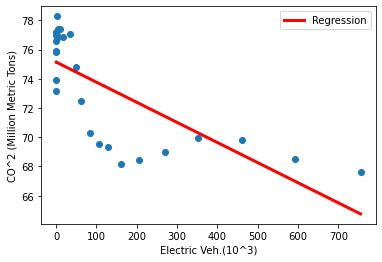

In [91]:
plt.scatter(electric_car_dat, raod_emission_by_veh)
plt.plot(electric_car_dat, test_regression, c='r', linewidth=3, label='Regression')
plt.legend()
plt.xlabel('Electric Veh.(10^3)')
plt.ylabel('CO^2 (Million Metric Tons)')

plt.show()